# Code Adapted from
- http://d2l.ai/chapter_reinforcement-learning/value-iter.html
- https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/notebooks/unit4/unit4.ipynb

## Value Iteration

In [21]:
%matplotlib inline
import random
import numpy as np
from d2l import torch as d2l

seed = 0  # Random number generator seed
gamma = 0.95  # Discount factor
num_iters = 10  # Number of iterations
random.seed(seed)  # Set the random seed to ensure results can be reproduced
np.random.seed(seed)

# Now set up the environment
env_info = d2l.make_env('FrozenLake-v1', seed=seed)

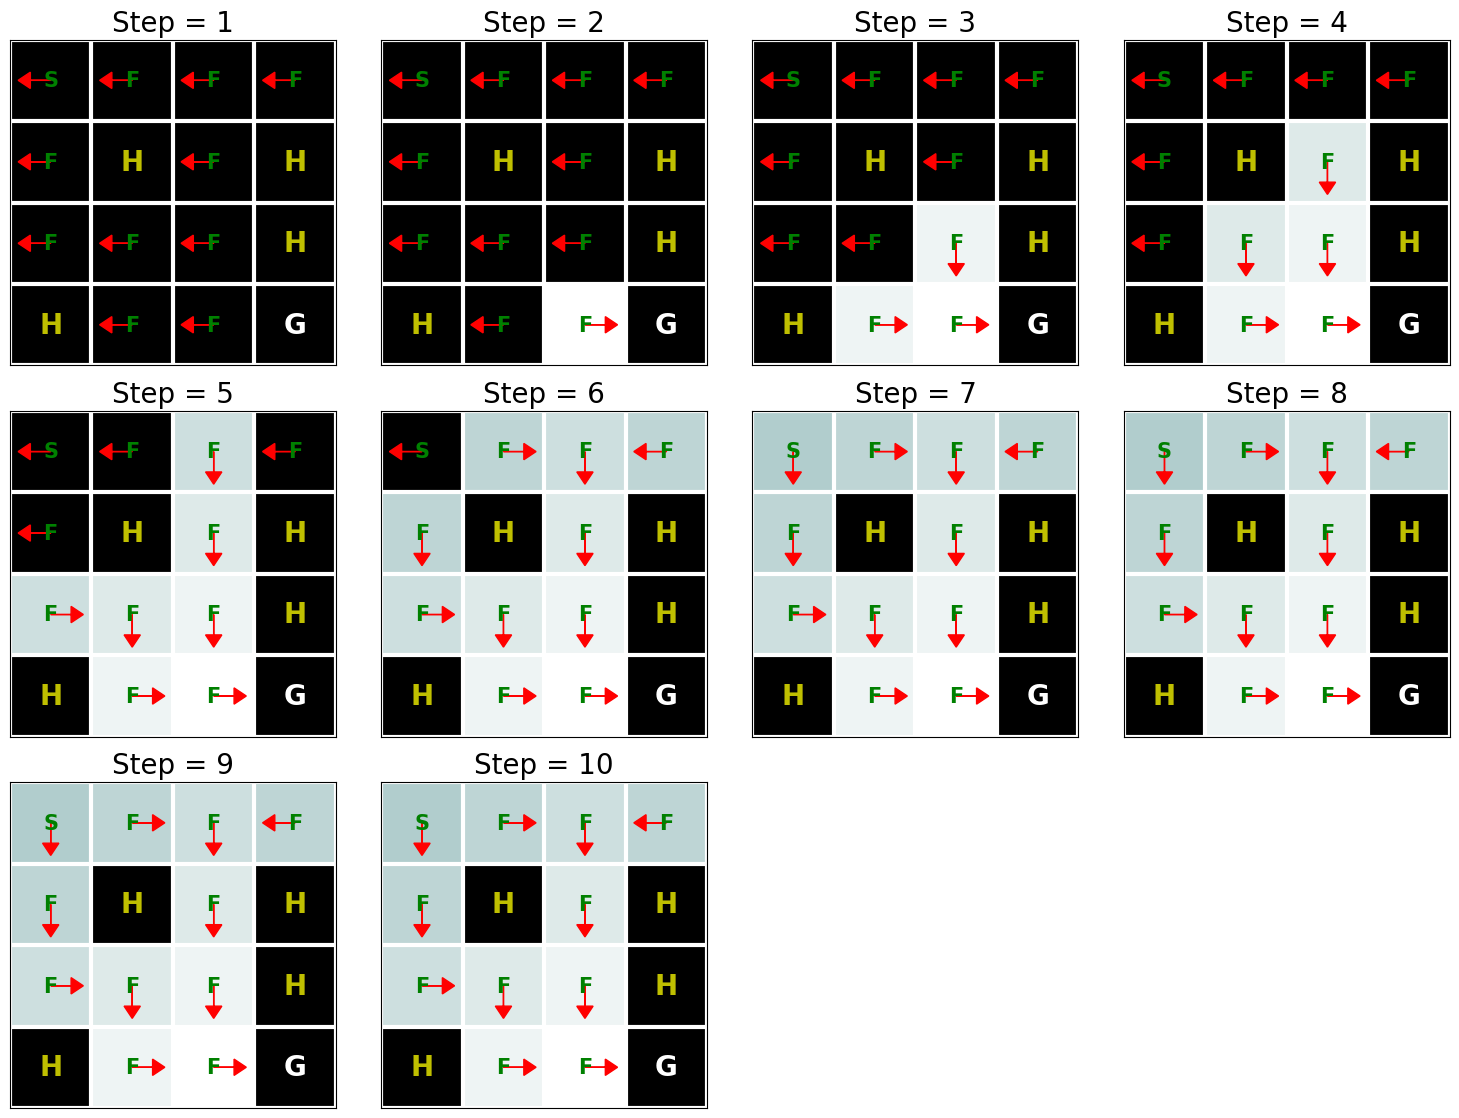

In [22]:
def value_iteration(env_info, gamma, num_iters):
    env_desc = env_info['desc']  # 2D array shows what each item means
    prob_idx = env_info['trans_prob_idx']
    nextstate_idx = env_info['nextstate_idx']
    reward_idx = env_info['reward_idx']
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']
    mdp = env_info['mdp']

    V  = np.zeros((num_iters + 1, num_states))
    Q  = np.zeros((num_iters + 1, num_states, num_actions))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        for s in range(num_states):
            for a in range(num_actions):
                # Calculate \sum_{s'} p(s'\mid s,a) [r + \gamma v_k(s')]
                for pxrds in mdp[(s,a)]:
                    # mdp(s,a): [(p1,next1,r1,d1),(p2,next2,r2,d2),..]
                    pr = pxrds[prob_idx]  # p(s'\mid s,a)
                    nextstate = pxrds[nextstate_idx]  # Next state
                    reward = pxrds[reward_idx]  # Reward
                    Q[k,s,a] += pr * (reward + gamma * V[k - 1, nextstate])
            # Record max value and max action
            V[k,s] = np.max(Q[k,s,:])
            pi[k,s] = np.argmax(Q[k,s,:])
    d2l.show_value_function_progress(env_desc, V[:-1], pi[:-1])

value_iteration(env_info=env_info, gamma=gamma, num_iters=num_iters)

## Q-Learning

In [23]:
gamma = 0.95  # Discount factor
num_iters = 256  # Number of iterations
alpha   = 0.9  # Learning rate
epsilon = 0.9  # Epsilon in epsilion gready algorithm
random.seed(seed)  # Set the random seed
np.random.seed(seed)

# Now set up the environment
env_info = d2l.make_env('FrozenLake-v1', seed=seed)

In [24]:
def e_greedy(env, Q, s, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()

    else:
        return np.argmax(Q[s,:])

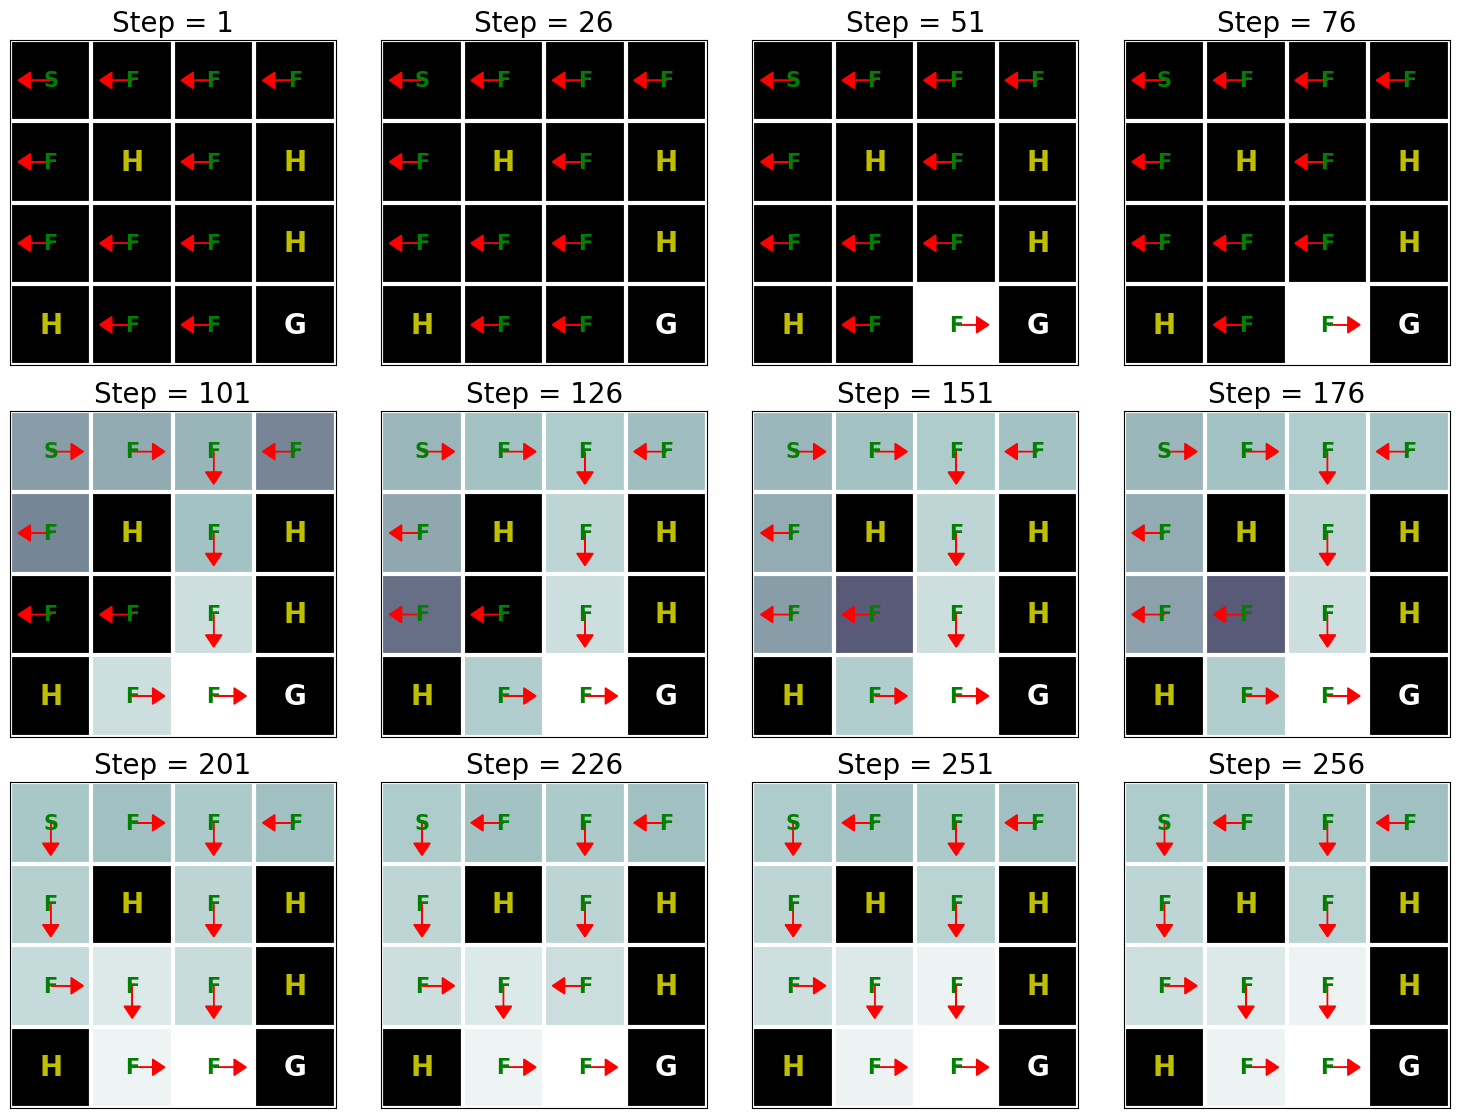

In [25]:
def q_learning(env_info, gamma, num_iters, alpha, epsilon):
    env_desc = env_info['desc']  # 2D array specifying what each grid item means
    env = env_info['env']  # 2D array specifying what each grid item means
    num_states = env_info['num_states']
    num_actions = env_info['num_actions']

    Q  = np.zeros((num_states, num_actions))
    V  = np.zeros((num_iters + 1, num_states))
    pi = np.zeros((num_iters + 1, num_states))

    for k in range(1, num_iters + 1):
        # Reset environment
        state, done = env.reset(), False
        while not done:
            # Select an action for a given state and acts in env based on selected action
            action = e_greedy(env, Q, state, epsilon)
            next_state, reward, done, _ = env.step(action)

            # Q-update:
            y = reward + gamma * np.max(Q[next_state,:])
            Q[state, action] = Q[state, action] + alpha * (y - Q[state, action])

            # Move to the next state
            state = next_state
        # Record max value and max action for visualization purpose only
        for s in range(num_states):
            V[k,s]  = np.max(Q[s,:])
            pi[k,s] = np.argmax(Q[s,:])
    d2l.show_Q_function_progress(env_desc, V[:-1], pi[:-1])

q_learning(env_info=env_info, gamma=gamma, num_iters=num_iters, alpha=alpha, epsilon=epsilon)
# This takes a while because instead of iterating across states as before, we follow the trajectory of the policy

## Deep RL (Policy Gradient)

In [30]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
import gym_pygame

import imageio

In [29]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [31]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [32]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t) 
        n_steps = len(rewards) 
        # Compute the discounted returns at each timestep,
        # as 
        #      the sum of the gamma-discounted return at time t (G_t) + the reward at time t
        #
        # In O(N) time, where N is the number of time steps
        # (this definition of the discounted return G_t follows the definition of this quantity 
        # shown at page 44 of Sutton&Barto 2017 2nd draft)
        # G_t = r_(t+1) + r_(t+2) + ...
        
        # Given this formulation, the returns at each timestep t can be computed 
        # by re-using the computed future returns G_(t+1) to compute the current return G_t
        # G_t = r_(t+1) + gamma*G_(t+1)
        # G_(t-1) = r_t + gamma* G_t
        # (this follows a dynamic programming approach, with which we memorize solutions in order 
        # to avoid computing them multiple times)
        
        # This is correct since the above is equivalent to (see also page 46 of Sutton&Barto 2017 2nd draft)
        # G_(t-1) = r_t + gamma*r_(t+1) + gamma*gamma*r_(t+2) + ...
        
        
        ## Given the above, we calculate the returns at timestep t as: 
        #               gamma[t] * return[t] + reward[t]
        #
        ## We compute this starting from the last timestep to the first, in order
        ## to employ the formula presented above and avoid redundant computations that would be needed 
        ## if we were to do it from first to last.
        
        ## Hence, the queue "returns" will hold the returns in chronological order, from t=0 to t=n_steps
        ## thanks to the appendleft() function which allows to append to the position 0 in constant time O(1)
        ## a normal python list would instead require O(N) to do this.
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )    
            
        ## standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        ## eps is the smallest representable float, which is 
        # added to the standard deviation of the returns to avoid numerical instabilities        
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        
        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()
        
        # Line 8: PyTorch prefers gradient descent 
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        
    return scores

In [33]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"], 
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"], 
                   100)

In [34]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

evaluate_agent(eval_env, 
               cartpole_hyperparameters["max_t"], 
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)